# Model Training on CERVAI2_min_side_300 Dataset

## About:

Author(s): Fahad (sfahadahmed@gmail.com)

This notebook contains multiclass classification code for training the EfficientNet model on the CERVAI2_min_side_300 dataset.







## Import Libraries

In [ ]:
import os
import shutil
import glob2

import random
import math

import numpy as np
import pandas as pd 

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow, show

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

## Preprocessing

In [ ]:
DATA_DIR = 'dataset/'
TRAIN_DIR = 'dataset/train/'
VAL_DIR = 'dataset/val/'
TEST_DIR = 'dataset/test/'

In [ ]:
classes = os.listdir(TRAIN_DIR)
classes

['NILM', 'ASC-H', 'SCC', 'HSIL', 'ASC-US', 'LSIL']

In [ ]:
NUM_CLASSES = len(classes)
NUM_CLASSES

6

### Organize samples for each class

In [ ]:
files_by_class = {}
for i in range(NUM_CLASSES):
    obj = {}
    obj['images'] = glob2.glob(TRAIN_DIR+classes[i]+'/*.jpg')
    obj['num_images'] = len(obj['images'])
    files_by_class[classes[i]] = obj

In [ ]:
files_by_class.keys()

dict_keys(['NILM', 'ASC-H', 'SCC', 'HSIL', 'ASC-US', 'LSIL'])

### Show sample count for each class

In [ ]:
total_images = 0
for k in files_by_class:
    obj = files_by_class[k]
    total_images += int(obj['num_images'])
    print(k,': ', obj['num_images'])

print('Total: ', total_images)

NILM :  1419
ASC-H :  1053
SCC :  352
HSIL :  2918
ASC-US :  532
LSIL :  737
Total:  7011


#### Top images per each class

In [ ]:
image_samples = {}
for c in classes:
    filepath = glob2.glob(TRAIN_DIR+c+'/*.jpg')[0]
    print(c + ' - ' + filepath)
    image_samples[c] = filepath

NILM - dataset/train/NILM/NILM_06862_CDET.jpg
ASC-H - dataset/train/ASC-H/ASC-H_04817_CDET.jpg
SCC - dataset/train/SCC/SCC_3 (1)_MEND.jpg
HSIL - dataset/train/HSIL/HSIL_04664_CDET.jpg
ASC-US - dataset/train/ASC-US/ASC-US_03194_CDET.jpg
LSIL - dataset/train/LSIL/LSIL_00144_CDET.jpg


## Visualize

Text(0.5, 1.0, 'SCC (300,400)')

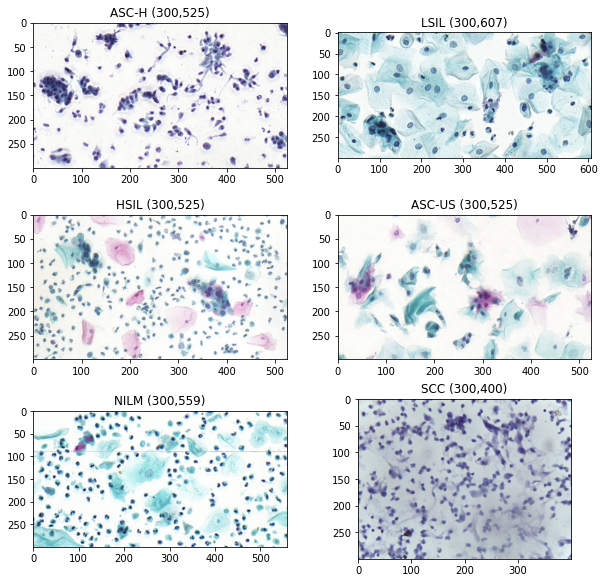

In [ ]:
f, axarr = plt.subplots(3,2)

f.set_figwidth(10)
f.set_figheight(10)

img = plt.imread(image_samples['ASC-H'])
axarr[0,0].imshow(img)
axarr[0,0].set_title('ASC-H ('+str(img.shape[0])+','+str(img.shape[1])+')')

img = plt.imread(image_samples['LSIL'])
axarr[0,1].imshow(img)
axarr[0,1].set_title('LSIL ('+str(img.shape[0])+','+str(img.shape[1])+')')

img = plt.imread(image_samples['HSIL'])
axarr[1,0].imshow(img)
axarr[1,0].set_title('HSIL ('+str(img.shape[0])+','+str(img.shape[1])+')')

img = plt.imread(image_samples['ASC-US'])
axarr[1,1].imshow(img)
axarr[1,1].set_title('ASC-US ('+str(img.shape[0])+','+str(img.shape[1])+')')

img = plt.imread(image_samples['NILM'])
axarr[2,0].imshow(img)
axarr[2,0].set_title('NILM ('+str(img.shape[0])+','+str(img.shape[1])+')')

img = plt.imread(image_samples['SCC'])
axarr[2,1].imshow(img)
axarr[2,1].set_title('SCC ('+str(img.shape[0])+','+str(img.shape[1])+')')

**we can see that there are different dimensions of images in the dataset. For training, we will need to preprocess these to be all of the same size. Lets say 300x300**

## Modeling

In [ ]:
EPOCHS = 200
BATCH_SIZE = 32
LEARNING_RATE = 0.001
IMAGE_SIZE = (300,300)

### Dataset Loading and Preprocessing

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255)

train_data = train_datagen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb')

val_data = train_datagen.flow_from_directory(
    directory=VAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb')

test_datagen = ImageDataGenerator(rescale=1/255)

test_data = test_datagen.flow_from_directory(directory=TEST_DIR, 
                                              target_size=IMAGE_SIZE,
                                              batch_size=BATCH_SIZE,
                                              class_mode='categorical',
                                              color_mode='rgb',
                                              shuffle=True
                                              )

Found 7011 images belonging to 6 classes.
Found 890 images belonging to 6 classes.
Found 871 images belonging to 6 classes.


### Reusable Functions

In [ ]:
# Model definition
def create_model(model_url):
  top_layer = hub.KerasLayer(model_url,
                             trainable=False,
                             name='feature_extraction_layer',
                             input_shape=IMAGE_SIZE+(3,))
  
  model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(NUM_CLASSES, activation='softmax', name='output_layer')
  ])

  return model

In [ ]:
class MyCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs={}):
        print(logs.get('accuracy'))
        if(logs.get('accuracy') > 0.98):
            self.model.stop_training = True

In [ ]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('epochs')
  plt.legend();

### Selected Model : EfficientNet V2

In [ ]:
tf.keras.backend.clear_session()
efficientnet_model = create_model('https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2')
efficientnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1536)             12930622  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 6)                 9222      
                                                                 
Total params: 12,939,844
Trainable params: 9,222
Non-trainable params: 12,930,622
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE) 
efficientnet_model.compile(optimizer,
                           'categorical_crossentropy',
                            metrics=['accuracy',
                                    tf.keras.metrics.Precision(name='precision'),
                                    tf.keras.metrics.Recall(name='recall'),
                                    tf.keras.metrics.AUC(name='auc')])

In [ ]:
# Train the model
efficientnet_history = efficientnet_model.fit(train_data,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = val_data,
    callbacks=[MyCallback()])


Epoch 1/200
220/220 [==============================] - 50s 229ms/step - loss: 0.5975 - accuracy: 0.7775 - precision: 0.8134 - recall: 0.7317 - auc: 0.9629 - val_loss: 0.5859 - val_accuracy: 0.7820 - val_precision: 0.8143 - val_recall: 0.7438 - val_auc: 0.9636
Epoch 2/200
220/220 [==============================] - 46s 207ms/step - loss: 0.5493 - accuracy: 0.8015 - precision: 0.8341 - recall: 0.7638 - auc: 0.9679 - val_loss: 0.6424 - val_accuracy: 0.7539 - val_precision: 0.7707 - val_recall: 0.7326 - val_auc: 0.9593
Epoch 3/200
220/220 [==============================] - 46s 207ms/step - loss: 0.4943 - accuracy: 0.8180 - precision: 0.8509 - recall: 0.7861 - auc: 0.9740 - val_loss: 0.5451 - val_accuracy: 0.8067 - val_precision: 0.8356 - val_recall: 0.7652 - val_auc: 0.9690
Epoch 4/200
220/220 [==============================] - 45s 203ms/step - loss: 0.4700 - accuracy: 0.8296 - precision: 0.8583 - recall: 0.7972 - auc: 0.9762 - val_loss: 0.6015 - val_accuracy: 0.7775 - val_precision: 0.7972

## Training Visualization

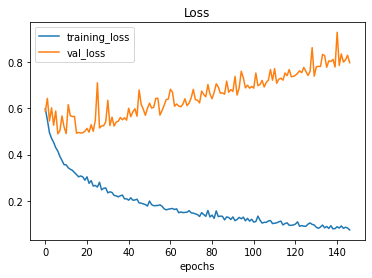

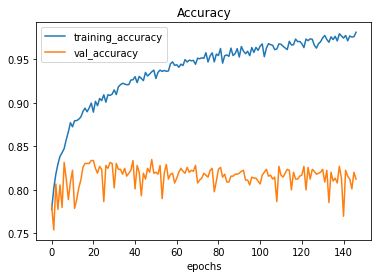

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
# Evaluate on the test set
efficientnet_loss, efficientnet_acc, efficientnet_precision, efficientnet_recall, efficientnet_auc = efficientnet_model.evaluate(test_data)

28/28 [==============================] - 5s 178ms/step - loss: 0.9146 - accuracy: 0.8232 - precision: 0.8266 - recall: 0.8209 - auc: 0.9532


#### The model seems to show good results. It needs some more optimization and also the confusion matrix.

In [ ]:
# TODO: include the confusion matrix